In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
from glob import iglob

In [ ]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.25.2 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


In [ ]:
# the directory with the `.h5` file
# use gene symbols for the variable names (variables-axis index)
output_data_dir="/content/drive/MyDrive/LeoDai/Private_Data/Clustering/Chimp"
output_fig_dir="/content/drive/MyDrive/LeoDai/Private_Data/Clustering/Chimp/Figs"
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/Preprocessing/chimp"
sc.settings.figdir = output_fig_dir

In [ ]:
#read in glial cells
sub_adata = sc.read(os.path.join(input_dir,"glial_filt_norm.h5ad"))
print(sub_adata)
sub_smplist = sub_adata.obs_names.tolist()

raw_adata = sc.read(os.path.join(input_dir,"chimp_all_raw_filt.h5ad"))

adata = raw_adata[raw_adata.obs_names.isin(sub_smplist),:]
print(adata)

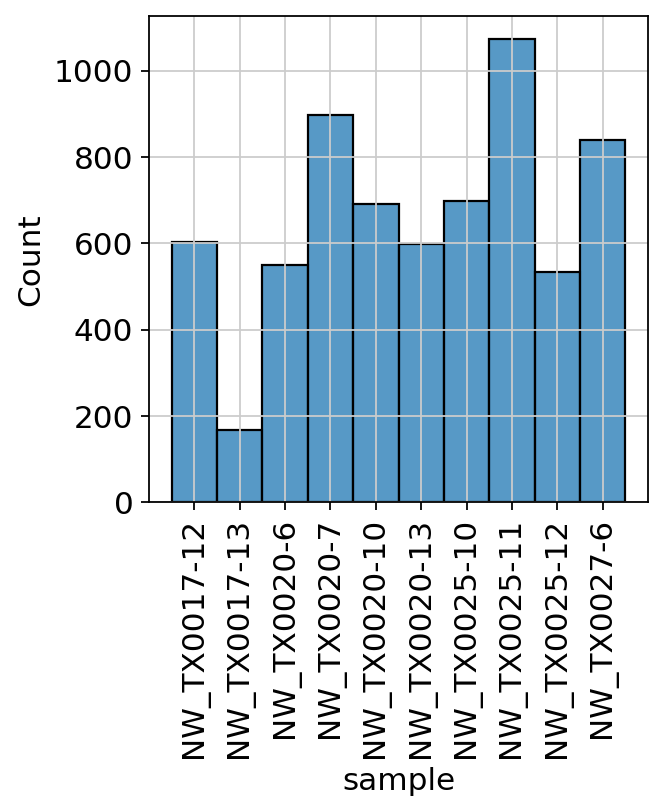

In [ ]:
#print(sub_adata.obs['sample'].value_counts())
#fig, axs = plt.subplots(1,1,figsize=(5,10))
plot = sns.histplot(adata.obs["sample"], kde=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"glial_sample_dist.png"),bbox_inches="tight")

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


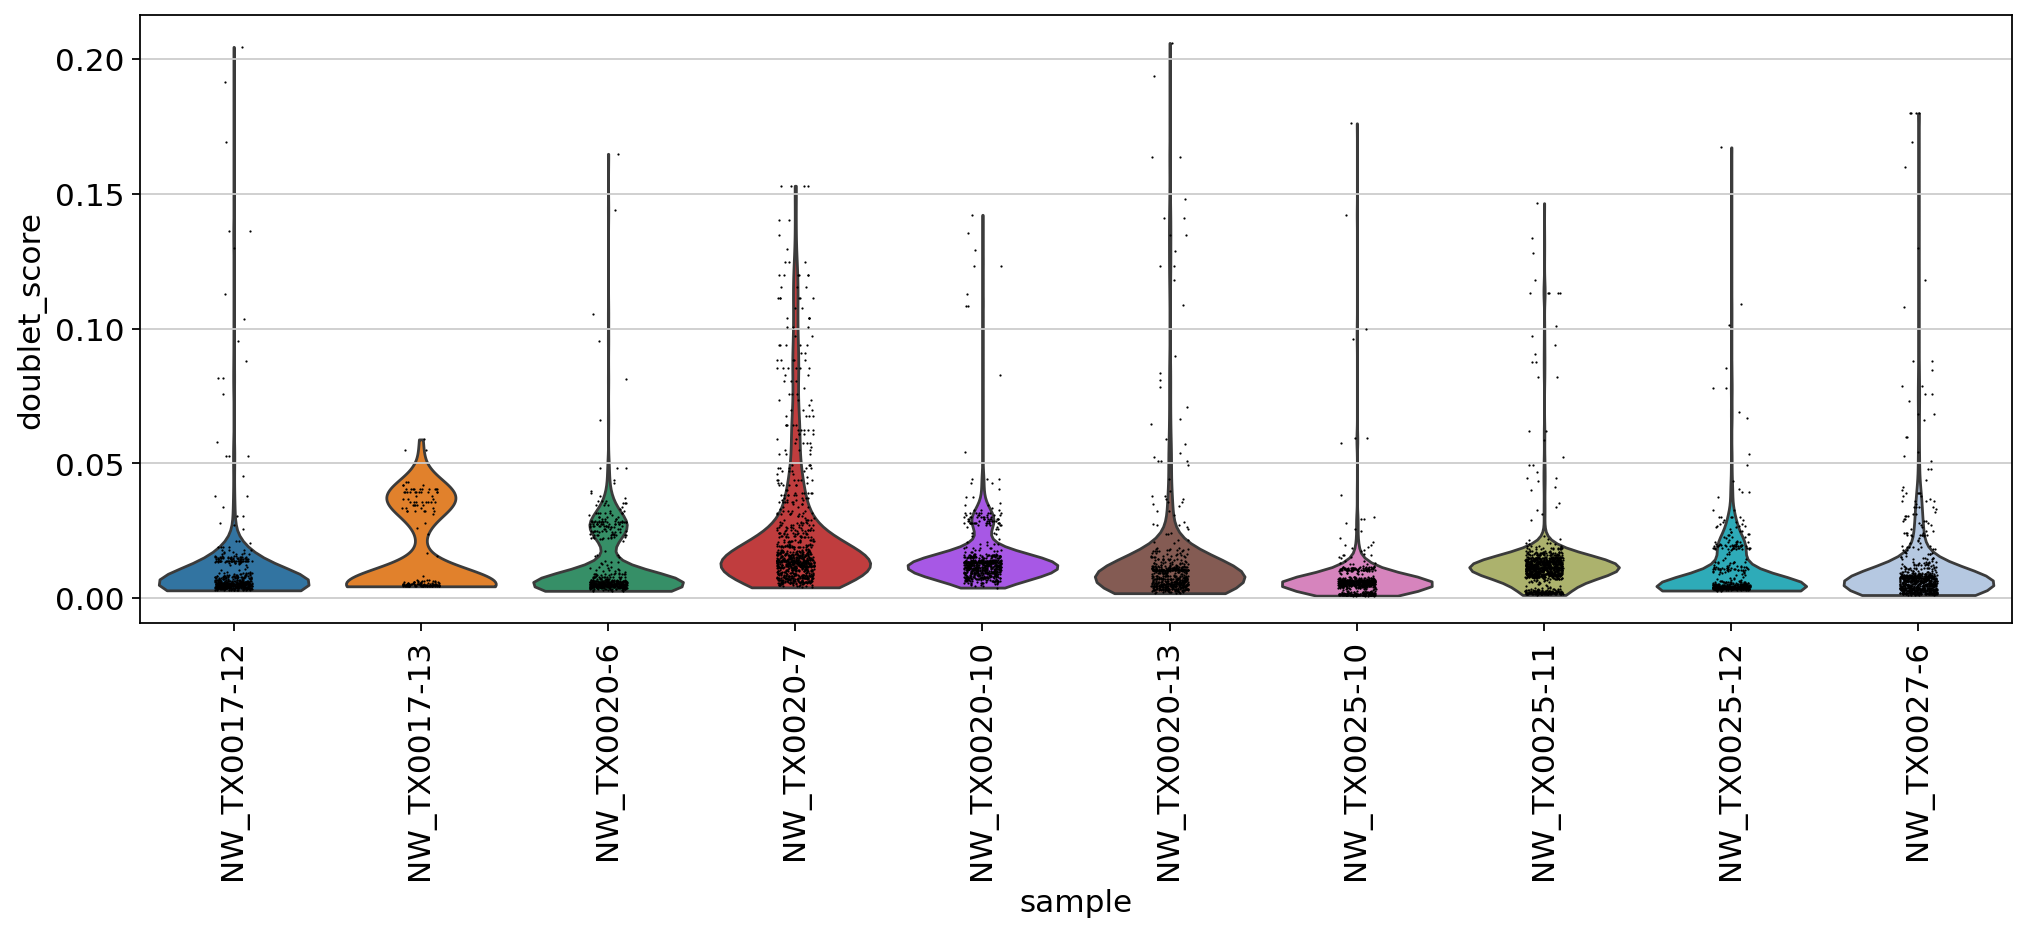

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plot = sc.pl.violin(adata, keys="doublet_score", groupby="sample", ax=axs, show=False)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(output_fig_dir,"glial_doublet_score.png"),bbox_inches="tight")

In [ ]:
# calculate percent ribosomal genes
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
## the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
#adata.obs['percent_ribo'] = np.sum(
#    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

False    19146
Name: mt, dtype: int64


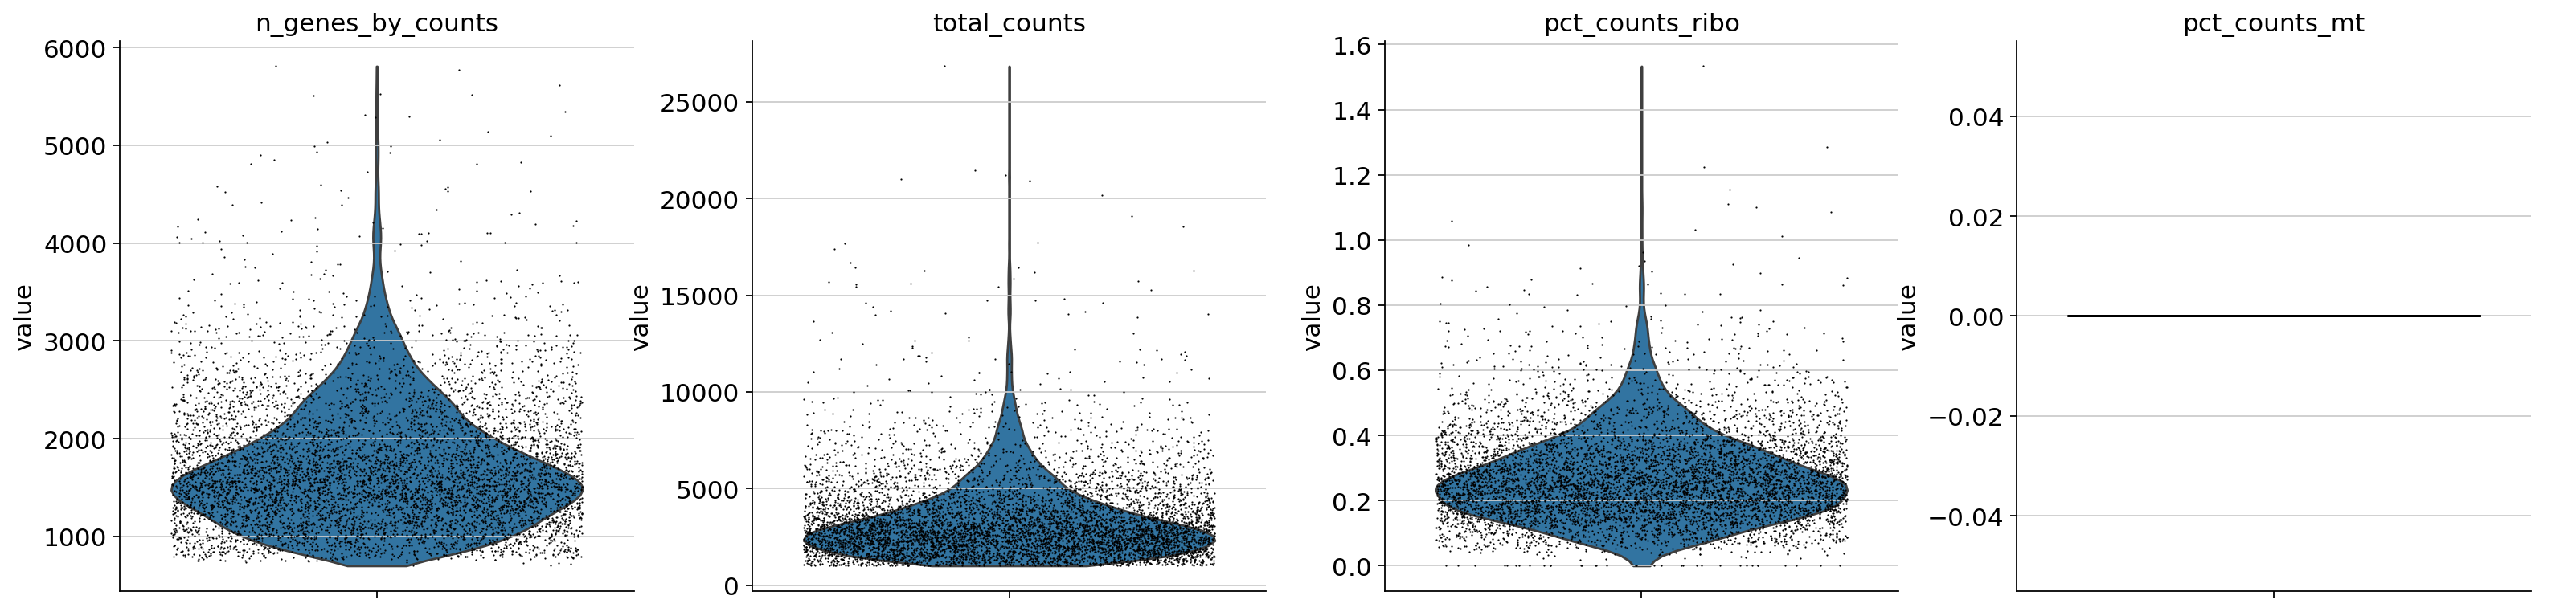

In [ ]:
# annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
print(adata.var['mt'].value_counts())
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ribo','pct_counts_mt'],jitter=0.4, multi_panel=True, show=False)
plt.savefig(os.path.join(output_fig_dir,"glial_mt_ribo_qc.png"))
#plt.show()

<Axes: xlabel='pct_dropout_by_counts', ylabel='Count'>

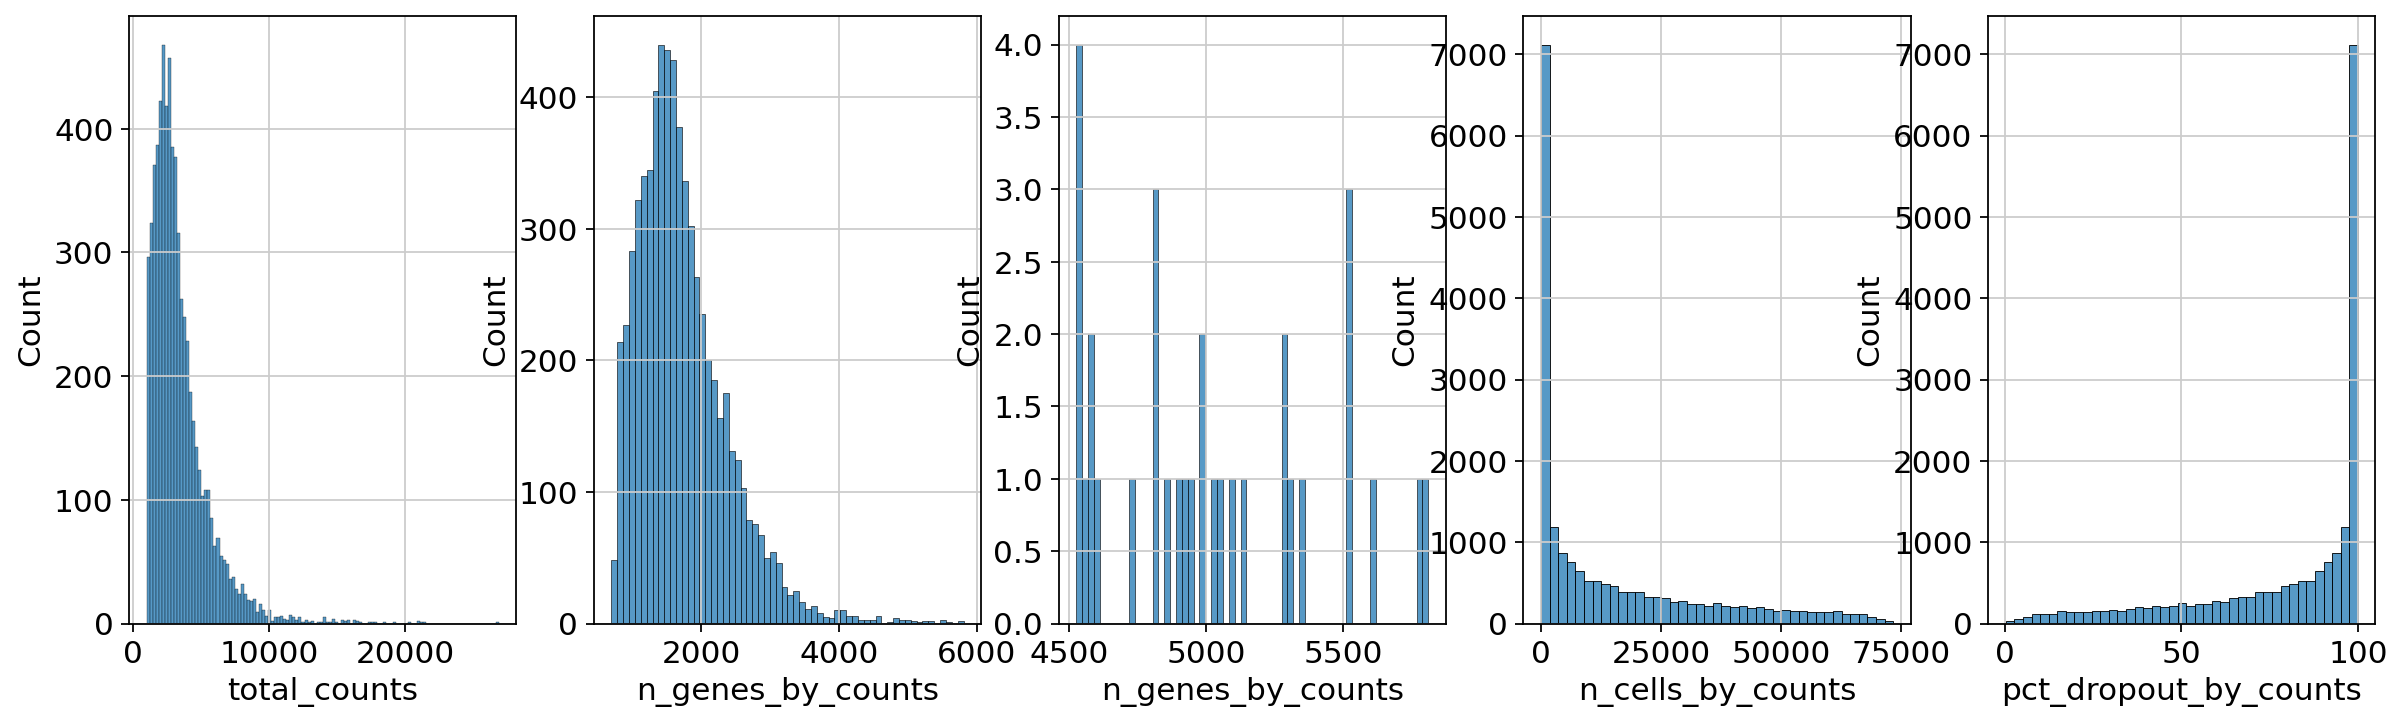

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"][sub_adata.obs["n_genes_by_counts"] > 4500], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.var["n_cells_by_counts"], kde=False, ax=axs[3])
sns.histplot(adata.var["pct_dropout_by_counts"], kde=False, ax=axs[4])
plt.savefig(os.path.join(output_fig_dir,"glial_counts_dist.png"))


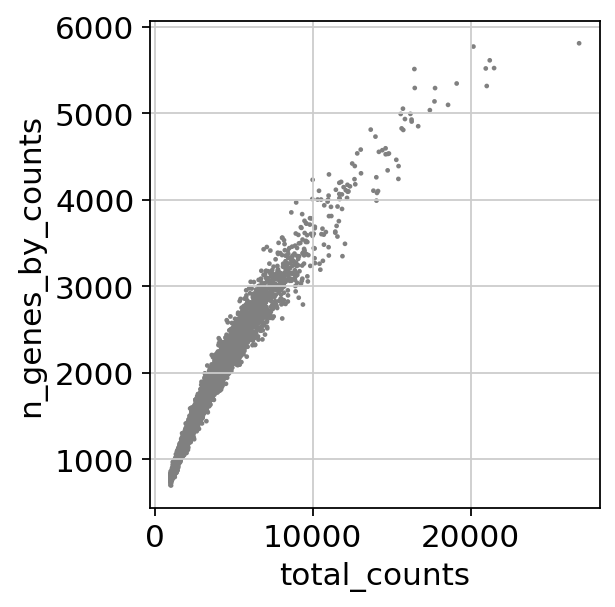

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',show=False)
plt.savefig(os.path.join(output_fig_dir,"glial_genes_by_counts.png"))
#Can color plot based on any variable from obs

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


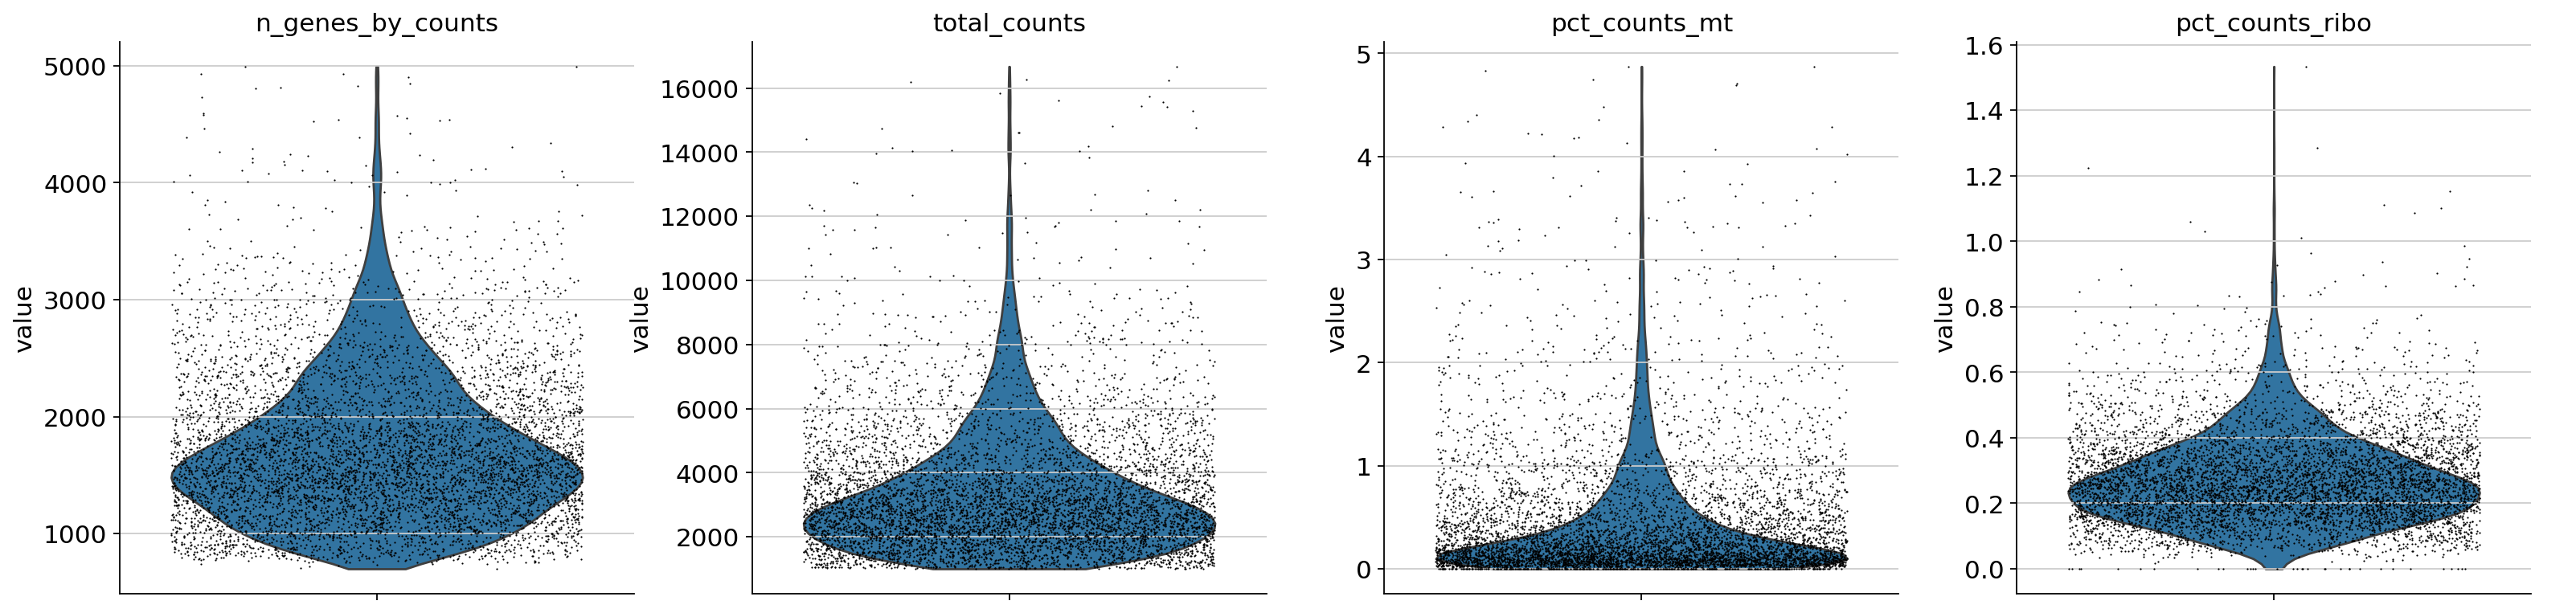

In [ ]:
#filter cells by number of genes per cell
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
#mitocondrial genes were removed in the processed adata, add it back from the raw_adata the percent counts mt to the adata of the specific cell class adata
adata.obs['pct_counts_mt'] = raw_adata[raw_adata.obs_names.isin(sub_smplist),:].obs['pct_counts_mt']
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],jitter=0.4, multi_panel=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"glial_filtering_genes_qc.png"))
#save a copy of adata after every major change

In [ ]:
#sc.pp.filter_cells(adata, max_counts=40000)
sc.pp.filter_genes(adata, min_cells=3)

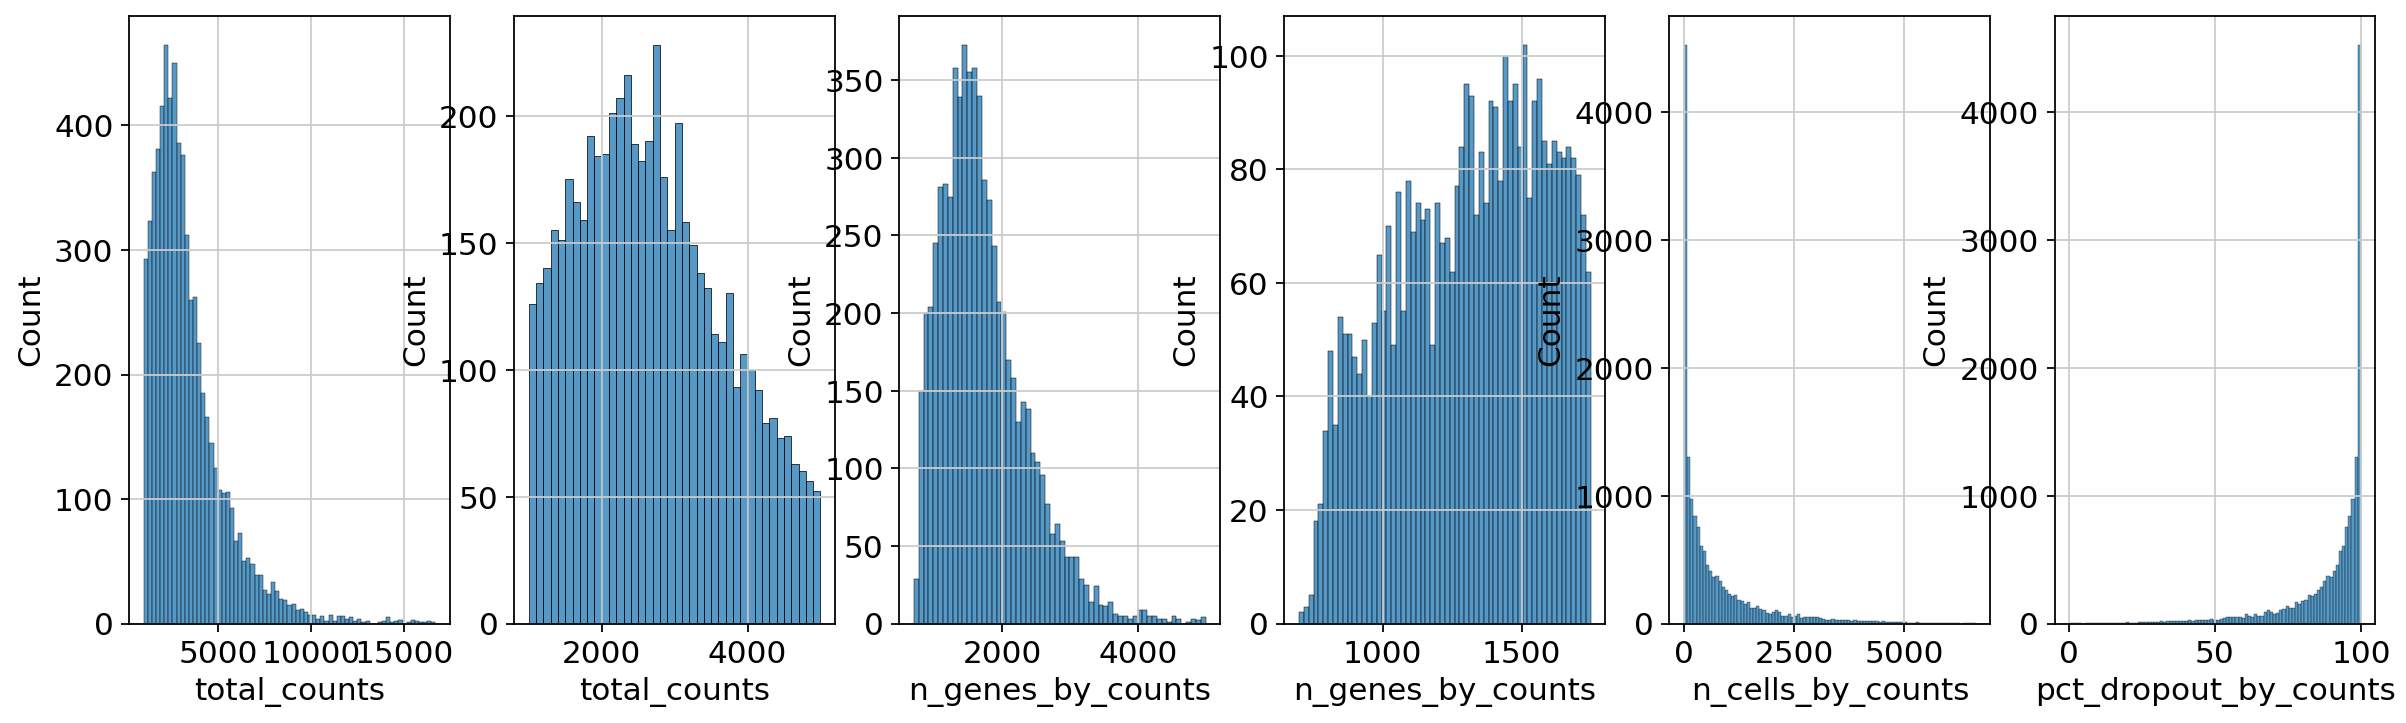

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 5000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1750], kde=False, bins=60, ax=axs[3])
sns.histplot(adata.var["n_cells_by_counts"], kde=False, ax=axs[4])
sns.histplot(adata.var["pct_dropout_by_counts"], kde=False, ax=axs[5])
plt.savefig(os.path.join(output_fig_dir,"after_filtering_counts_dist.png"))

In [ ]:
#normalization
#normalize to 10000 reads, log transformed,
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

In [ ]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor="seurat", batch_key='sample')
sc.pl.highly_variable_genes(adata,show=False)
plt.savefig(os.path.join(output_fig_dir,"glail_highly_variable_genes.png"))
print(len(adata.var_names[adata.var.highly_variable]))

In [ ]:
#save normalized adata
adata.raw = adata
hvg_df = pd.DataFrame()
hvg_df['gene'] = adata.var_names
hvg_df['hvg'] = adata.var.highly_variable.tolist()
hvg_df.to_csv(os.path.join(output_data_dir,"glial_hvg.txt"),index=False,sep="\t")
#ribosomal genes in highly variable genes
hvg_gene = adata.var_names[adata.var.highly_variable]

#The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed, and ribosomal gene expressed. Scale the data to unit variance.
adata = adata[:, adata.var.highly_variable]

print(adata)
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt','pct_counts_ribo'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


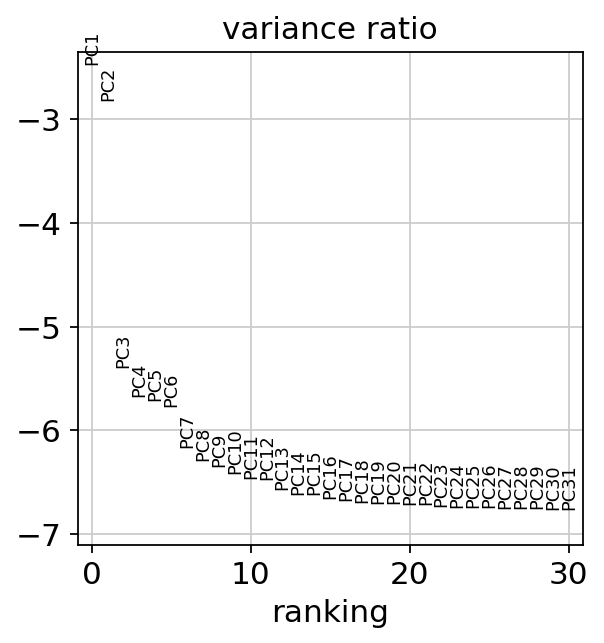

In [ ]:
#Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,show=False)
plt.savefig(os.path.join(output_fig_dir,"glial_pca_var_ratio.png"))

In [ ]:
#batch correction
sc.external.pp.harmony_integrate(adata, 'sample')
#replcae PCA by the batch corrected data
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


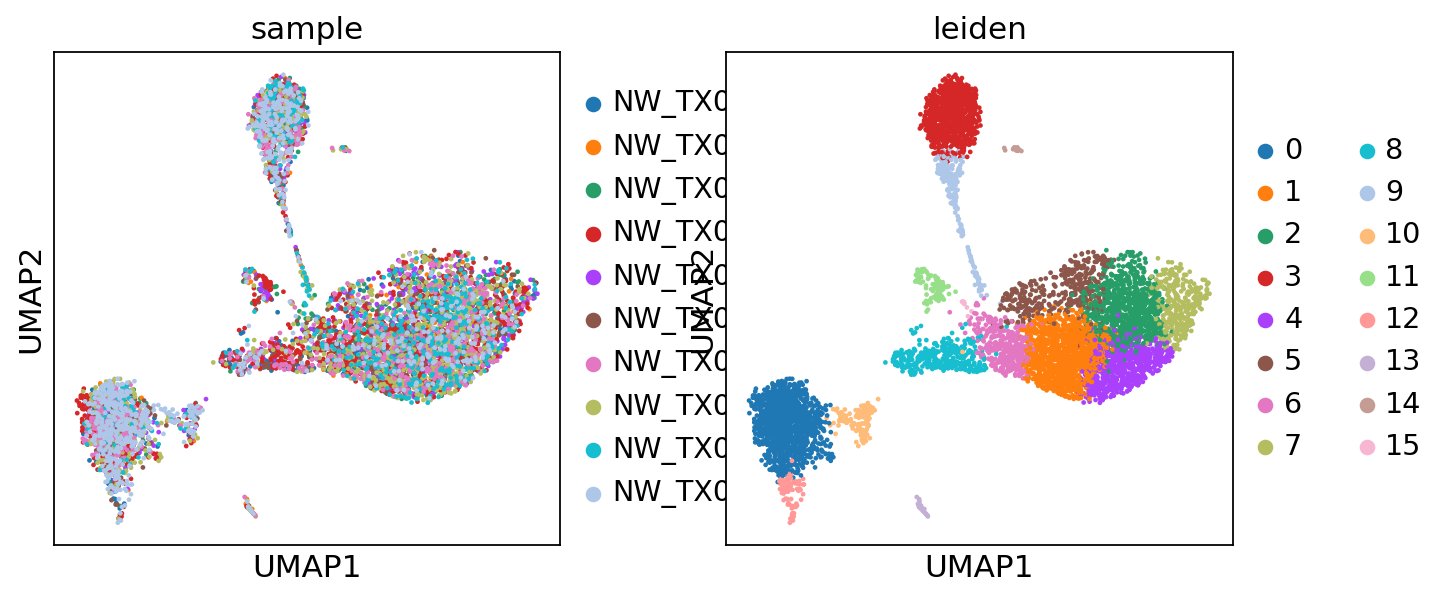

In [ ]:
sc.pl.umap(adata, color=["sample","leiden"], cmap="tab20",show=False)
plt.savefig(os.path.join(output_fig_dir,"glial_Harmony_umap_by_sample.png"))

In [ ]:
#calculate paga & plot
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False,show =False,use_raw=True)  # remove `plot=False` if you want to see the coarse-grained graph
#plt.savefig(os.path.join(output_dir,"paga_leiden_cluster.png"))

In [ ]:
#show which genes are active in which clusters for the three overall clusters (umap)
sc.tl.umap(adata, init_pos='paga')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [ ]:
marker_genes= ['ALDH1L1', 'GFAP', 'PDGFRA','VCAN','MBP', 'TYROBP','OPALIN', 'MOBP', 'CLDN11','COL20A1', 'IL1R1','SLC1A3','INPP5D','COLEC12','MCAM','CXCL12','SRGN']


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


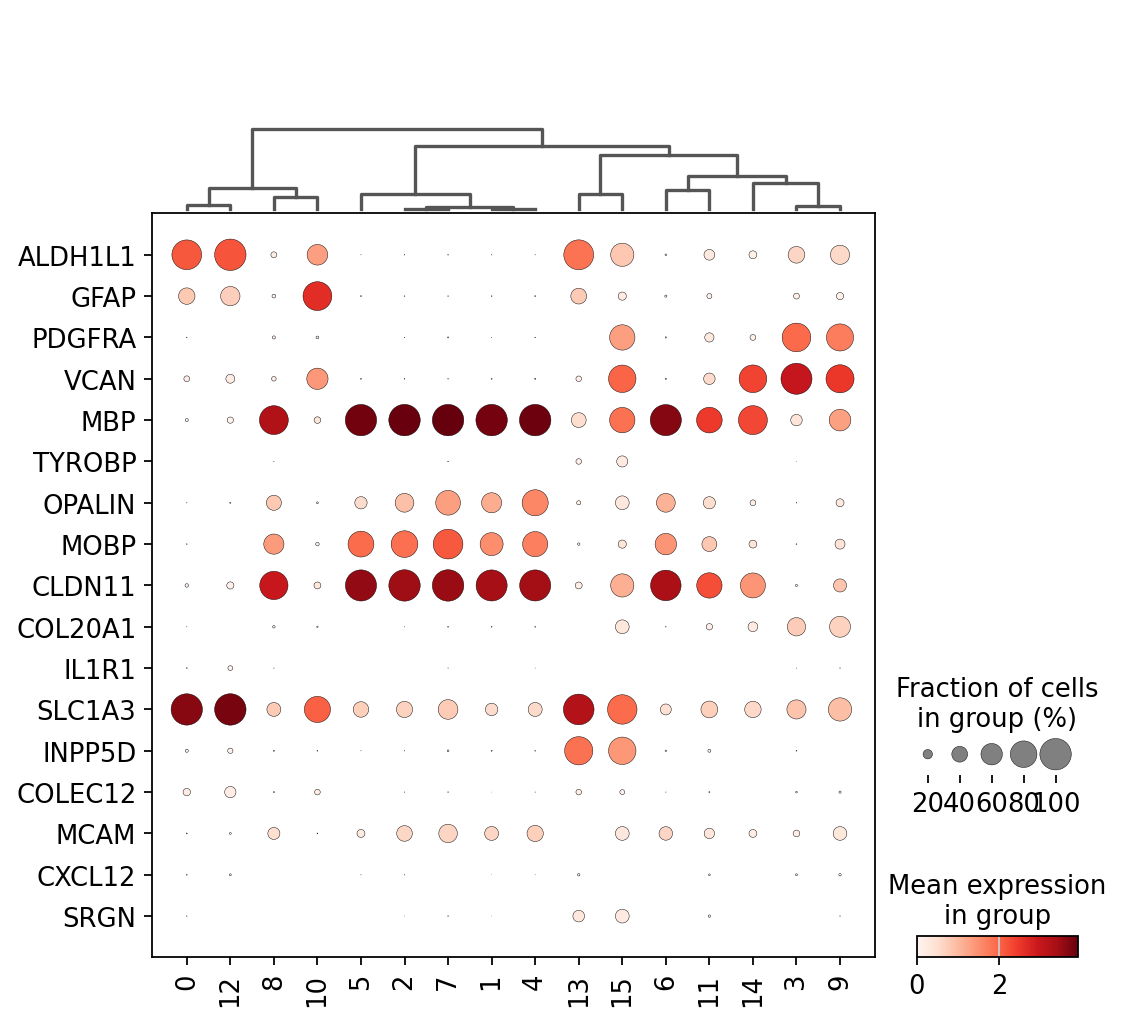

In [ ]:
sc.pl.dotplot(adata, var_names=marker_genes, groupby="leiden", dendrogram=True, swap_axes=True)

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

In [ ]:
#Get the most variable genes that define each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,show=False)
plt.savefig(os.path.join(output_fig_dir,"glial_level2_rank_genes_groups.png"))

In [ ]:
#print(adata)
marker_g0 = [g for g in adata.uns['rank_genes_groups']['names'][0]]
marker_g1 = [g for g in adata.uns['rank_genes_groups']['names'][1]]
marker_g2 = [g for g in adata.uns['rank_genes_groups']['names'][2]]

In [ ]:
#print(np.array(marker_g0))
high_express_genes_toremove = ['PCDH9','LSAMP']
marker_g0.remove("PCDH9")
marker_g0.remove("LSAMP")

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


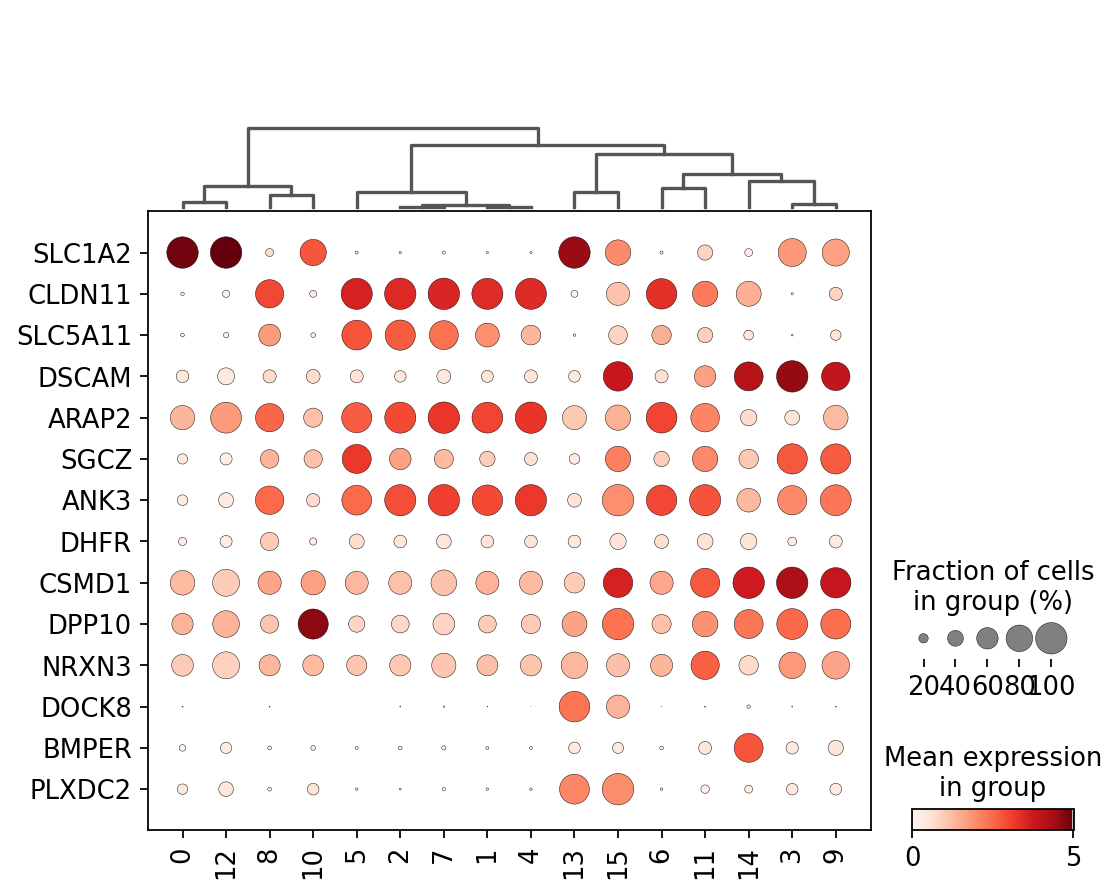

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


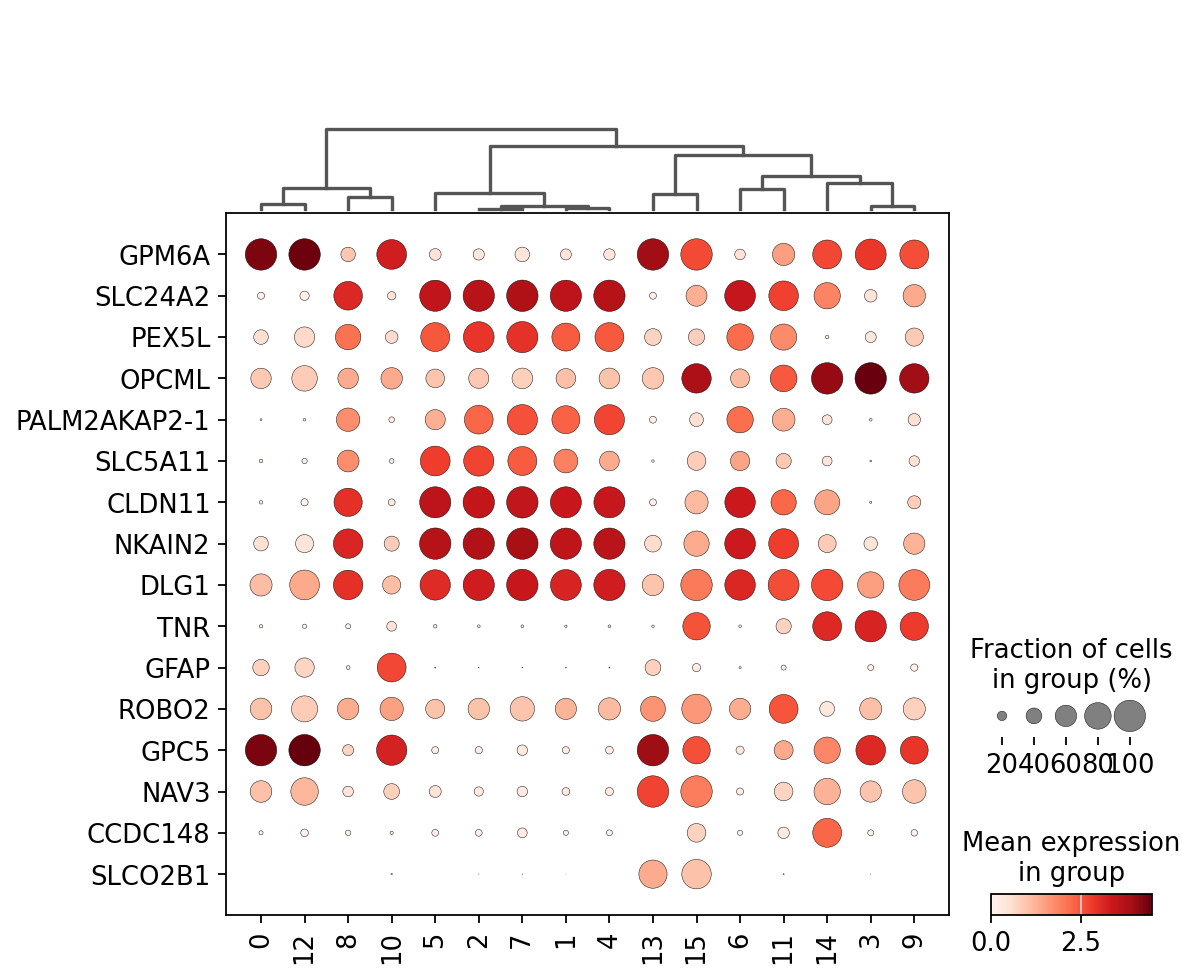

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


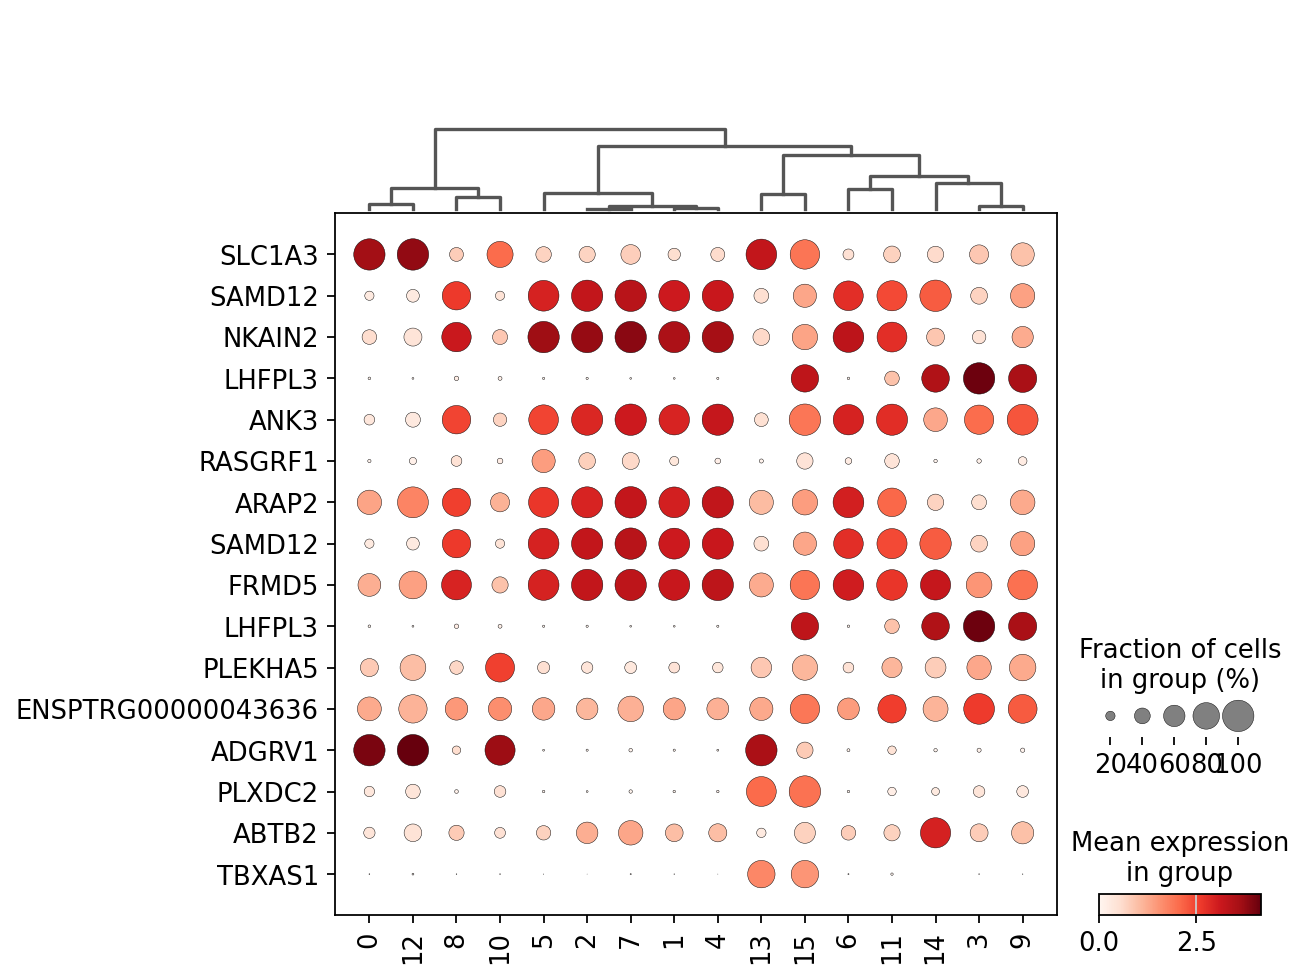

In [ ]:
#del adata.uns['dendrogram_leiden']
sc.pl.dotplot(adata, var_names=marker_g0, groupby="leiden", dendrogram=True,swap_axes=True)
sc.pl.dotplot(adata, var_names=marker_g1, groupby="leiden", dendrogram=True,swap_axes=True)
sc.pl.dotplot(adata, var_names=marker_g2, groupby="leiden", dendrogram=True, swap_axes=True)
#sc.pl.stacked_violin(adata, marker_g0, groupby="leiden");

In [ ]:
level2_opc_smp = adata.obs_names[adata.obs.leiden.isin(("3","9","14"))]
level2_oligo_smp = adata.obs_names[adata.obs.leiden.isin(("1","2","4","5","6","7","8","11"))]
level2_astro_smp = adata.obs_names[adata.obs.leiden.isin(("0","12","10"))]
level2_vlmc_smp = adata.obs_names[adata.obs.leiden.isin(("13","15"))]

In [ ]:
adata.obs['subclass'] = np.empty([adata.n_obs], dtype=str)
for i in level2_opc_smp:
  adata.obs.loc[adata.obs_names.str.startswith(i), 'subclass'] = 'OPC'
for i in level2_astro_smp:
  adata.obs.loc[adata.obs_names.str.startswith(i), 'subclass'] = 'Astro'
for i in level2_vlmc_smp:
  adata.obs.loc[adata.obs_names.str.startswith(i), 'subclass'] = 'VLMC'
for i in level2_oligo_smp:
  adata.obs.loc[adata.obs_names.str.startswith(i), 'subclass'] = 'Oligo'

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


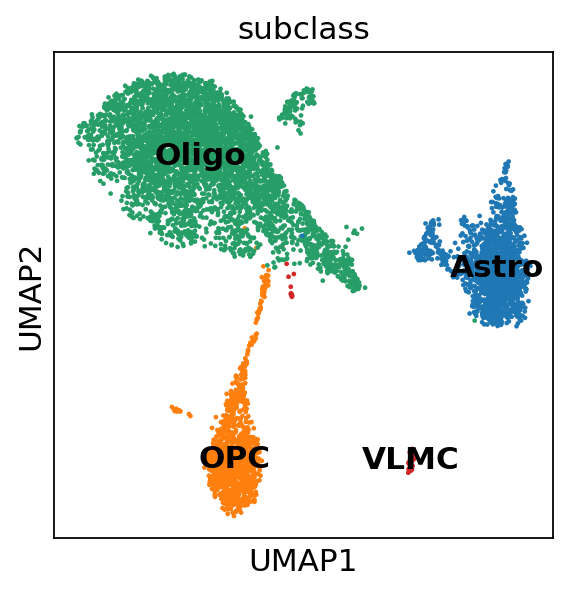

In [ ]:
sc.pl.umap(adata, color=["subclass"], cmap="tab20",show=False,legend_loc="on data")
plt.savefig(os.path.join(output_fig_dir,"glial_level2_subclass.png"))

In [ ]:
adata.obs['cluster_label'] = np.empty([adata.n_obs], dtype=str)
adata.obs.loc[adata.obs.leiden == "3", 'cluster_label'] = 'OPC1'
adata.obs.loc[adata.obs.leiden == "9", 'cluster_label'] = 'OPC2'
adata.obs.loc[adata.obs.leiden == "14", 'cluster_label'] = 'OPC3'
adata.obs.loc[adata.obs.leiden == "1", 'cluster_label'] = 'Oligo1'
adata.obs.loc[adata.obs.leiden == "2", 'cluster_label'] = 'Oligo2'
adata.obs.loc[adata.obs.leiden == "4", 'cluster_label'] = 'Oligo3'
adata.obs.loc[adata.obs.leiden == "5", 'cluster_label'] = 'Oligo4'
adata.obs.loc[adata.obs.leiden == "6", 'cluster_label'] = 'Oligo5'
adata.obs.loc[adata.obs.leiden == "7", 'cluster_label'] = 'Oligo6'
adata.obs.loc[adata.obs.leiden == "8", 'cluster_label'] = 'Oligo7'
adata.obs.loc[adata.obs.leiden == "11", 'cluster_label'] = 'Oligo8'
adata.obs.loc[adata.obs.leiden == "0", 'cluster_label'] = 'Astro1'
adata.obs.loc[adata.obs.leiden == "12", 'cluster_label'] = 'Astro2'
adata.obs.loc[adata.obs.leiden == "10", 'cluster_label'] = 'Astro3'
adata.obs.loc[adata.obs.leiden == "13", 'cluster_label'] = 'VLMC1'
adata.obs.loc[adata.obs.leiden == "15", 'cluster_label'] = 'Oligo7'

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


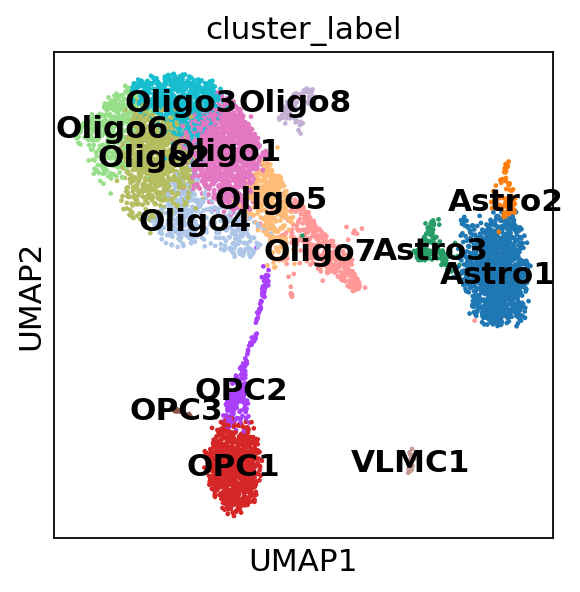

In [ ]:
sc.pl.umap(adata, color=["cluster_label"], cmap="tab20",show=False,legend_loc="on data")
plt.savefig(os.path.join(output_fig_dir,"glial_level3_cluster_label.png"))

In [ ]:
adata.write_h5ad(os.path.join(output_data_dir,"glial_level2_level3_cluster.h5ad"),compression='gzip')